In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [0]:
# MODEL_NAME = 'RNN'
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("MODEL_NAME = {}, DEVICE = {}".format(MODEL_NAME, DEVICE))

# Generate data

This is a toy example to predict a sequence with RNN.
In this example, Y is a sequence of 2D vectors (sin(x), cos(x)) for x in [-3.14, +3.14]

In practical applications, replace Y with the sequence to predict

In [0]:
# range of the data
X = np.linspace(-3.14 * 2, 3.14 * 2, 100)

In [133]:
Y = np.array([(np.sin(x), np.cos(x)) for x in X])
Y[:10]

array([[0.0031853 , 0.99999493],
       [0.12968768, 0.99155489],
       [0.25410545, 0.96717652],
       [0.3744387 , 0.92725167],
       [0.4887532 , 0.87242209],
       [0.59521143, 0.80356913],
       [0.69210219, 0.72179953],
       [0.77786803, 0.62842766],
       [0.85113036, 0.52495439],
       [0.91071154, 0.41304296]])

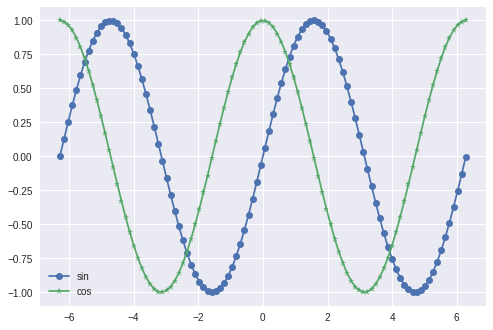

In [134]:
plt.plot(X, Y[:,0], label="sin", marker="o")
plt.plot(X, Y[:,1], label="cos", marker='*')
plt.legend()

# Convert numpy array to torch.Tensor

In [135]:
# convert Y into input tensors
#input_tensor = torch.tensor(Y, dtype=torch.float32).to(DEVICE)
input_tensor = torch.tensor(Y, dtype=torch.float32)
input_tensor.shape

torch.Size([100, 2])

In [136]:
# check input_tensor
input_tensor[:10]

tensor([[0.0032, 1.0000],
        [0.1297, 0.9916],
        [0.2541, 0.9672],
        [0.3744, 0.9273],
        [0.4888, 0.8724],
        [0.5952, 0.8036],
        [0.6921, 0.7218],
        [0.7779, 0.6284],
        [0.8511, 0.5250],
        [0.9107, 0.4130]])

In [137]:
# make target_tensor by rotating input_tensor
# target_tensor = torch.cat((input_tensor[1:], input_tensor[0:1]), 0).to(DEVICE)
target_tensor = torch.cat((input_tensor[1:], input_tensor[0:1]), 0)
target_tensor[:10]

tensor([[0.1297, 0.9916],
        [0.2541, 0.9672],
        [0.3744, 0.9273],
        [0.4888, 0.8724],
        [0.5952, 0.8036],
        [0.6921, 0.7218],
        [0.7779, 0.6284],
        [0.8511, 0.5250],
        [0.9107, 0.4130],
        [0.9557, 0.2945]])

In [138]:
# check the input and target tensors
print(torch.cat((input_tensor, target_tensor), 1)[:10])

tensor([[0.0032, 1.0000, 0.1297, 0.9916],
        [0.1297, 0.9916, 0.2541, 0.9672],
        [0.2541, 0.9672, 0.3744, 0.9273],
        [0.3744, 0.9273, 0.4888, 0.8724],
        [0.4888, 0.8724, 0.5952, 0.8036],
        [0.5952, 0.8036, 0.6921, 0.7218],
        [0.6921, 0.7218, 0.7779, 0.6284],
        [0.7779, 0.6284, 0.8511, 0.5250],
        [0.8511, 0.5250, 0.9107, 0.4130],
        [0.9107, 0.4130, 0.9557, 0.2945]])


# Create RNN Class

In [0]:
import torch
import torch.nn as nn


# RNN to predict the sequence

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
#        print("shape = {}, {}".format(input.shape, hidden.shape))
#        print("input = {}".format(input))
#        print("hidden = {}".format(hidden))
      
        input_combined = torch.cat((input, hidden), -1)
        
#        print("combined = {}".format(input_combined))
        
        hidden = self.i2h(input_combined)
        output = self.h2o(hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Train RNN

In [0]:
# define loss function

criterion = nn.MSELoss()

learning_rate = 0.0005


# define train function that trains for one step
def train(input_tensor, target_tensor):
#    hidden = rnn.initHidden().to(DEVICE)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_tensor.size(0)):
#        print("Input = {}, hidden = {}".format(input_tensor[i], hidden))
        output, hidden = rnn(input_tensor[i:i+1], hidden)
#        print("output = {}, target = {}".format(output, target_tensor[i:i+1]))
        l = criterion(output, target_tensor[i:i+1])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_tensor.size(0)

### Note that pytorch modules inputs a batch rather than a vector!

In [141]:
# input_tensor[0].shape = torch.Size([2])
input_tensor[0]

tensor([0.0032, 1.0000])

In [142]:
# input_tensor[0:1].shape = torch.Size([1, 2])
input_tensor[0:1]

tensor([[0.0032, 1.0000]])

In [0]:
# utility function to measure time
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
#rnn = RNN(2, 32, 2).to(DEVICE);
rnn = RNN(2, 32, 2)

In [154]:
n_iters = 10000
print_every = 200
plot_every = 200
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(input_tensor, target_tensor)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 3s (200 2%) 0.0026
0m 6s (400 4%) 0.0013
0m 9s (600 6%) 0.0008
0m 13s (800 8%) 0.0005
0m 16s (1000 10%) 0.0004
0m 19s (1200 12%) 0.0003
0m 22s (1400 14%) 0.0003
0m 26s (1600 16%) 0.0002
0m 29s (1800 18%) 0.0002
0m 32s (2000 20%) 0.0002
0m 36s (2200 22%) 0.0002
0m 39s (2400 24%) 0.0002
0m 42s (2600 26%) 0.0001
0m 45s (2800 28%) 0.0001
0m 49s (3000 30%) 0.0001
0m 52s (3200 32%) 0.0001
0m 55s (3400 34%) 0.0001
0m 58s (3600 36%) 0.0001
1m 2s (3800 38%) 0.0001


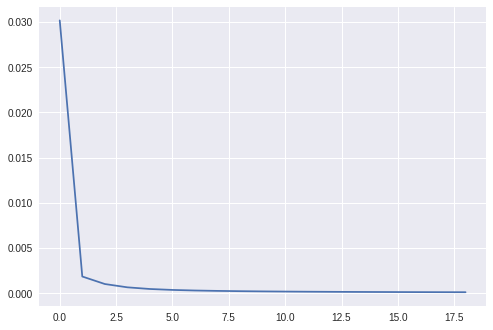

In [155]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [156]:
predict_tensor = torch.tensor([[np.sin(X[0]), np.cos(X[0])]])
predict_tensor

tensor([[0.0032, 1.0000]])

In [0]:
hidden = rnn.initHidden();

for i in range(1,len(X)):
#  print("input = {}".format(predict[-1:]))
#  print("hidden = {}".format(hidden))
  output, hidden = rnn(predict_tensor[-1:], hidden)
  predict_tensor = torch.cat((predict_tensor, output), 0)
#  print("predict = {}".format(predict))

In [158]:
predict_tensor[:10]

tensor([[0.0032, 1.0000],
        [0.1323, 0.9364],
        [0.2715, 0.9577],
        [0.3628, 0.9492],
        [0.4808, 0.8768],
        [0.5834, 0.7989],
        [0.6793, 0.7133],
        [0.7641, 0.6243],
        [0.8362, 0.5228],
        [0.8945, 0.4132]], grad_fn=<SliceBackward>)

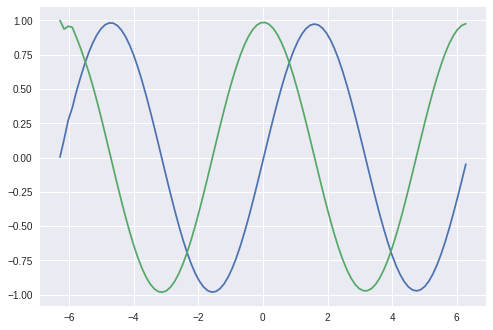

In [159]:
predict = predict_tensor.detach().numpy()
plt.plot (X, predict[:,0])
plt.plot (X, predict[:,1])
